<a href="https://colab.research.google.com/github/sarthag/Emotion-Detection/blob/main/Emotion_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import sys
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/Emotion_Detection') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import time

In [3]:
data = pd.read_csv('/content/gdrive/MyDrive/Emotion_Detection/fer2013.csv')
print(data.values.shape)
data.head(10)

(35887, 2306)


,emotion,Usage,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,2264,2265,2266,2267,2268,2269,2270,2271,2272,2273,2274,2275,2276,2277,2278,2279,2280,2281,2282,2283,2284,2285,2286,2287,2288,2289,2290,2291,2292,2293,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,0,Training,70,80,82,72,58,58,60,63,54,58,60,48,89,115,121,119,115,110,98,91,84,84,90,99,110,126,143,153,158,171,169,172,169,165,129,110,113,107,...,20,31,40,46,65,88,108,110,125,149,157,153,162,164,158,159,154,140,78,21,11,61,144,168,173,157,138,150,148,132,159,182,183,136,106,116,95,106,109,82
1,0,Training,151,150,147,155,148,133,111,140,170,174,182,154,153,164,173,178,185,185,189,187,186,193,194,185,183,186,180,173,166,161,147,133,172,151,114,161,161,146,...,150,129,143,135,115,102,111,124,112,109,132,146,135,149,148,143,163,156,159,150,139,128,116,125,133,109,130,147,130,121,105,108,95,108,102,67,171,193,183,184
2,2,Training,231,212,156,164,174,138,161,173,182,200,106,38,39,74,138,161,164,179,190,201,210,216,220,224,222,218,216,213,217,220,220,218,217,212,174,160,162,160,...,225,220,215,207,199,167,108,151,122,88,71,84,120,127,105,76,71,78,90,106,123,146,155,148,130,141,119,69,54,89,104,138,152,122,114,101,97,88,110,152
3,4,Training,24,32,36,30,32,23,19,20,30,41,21,22,32,34,21,19,43,52,13,26,40,59,65,12,20,63,99,98,98,111,75,62,41,73,118,140,192,186,...,124,150,161,167,169,167,162,164,169,181,172,168,169,170,174,179,180,182,196,208,226,230,140,113,114,125,135,141,172,214,174,126,132,132,133,136,139,142,143,142
4,6,Training,4,0,0,0,0,0,0,0,0,0,0,0,3,15,23,28,48,50,58,84,115,127,137,142,151,156,155,149,153,152,157,160,162,159,145,121,83,58,...,18,27,19,13,11,22,37,48,55,67,88,95,112,118,123,141,157,174,181,185,184,179,176,171,155,128,105,10,0,0,12,34,31,31,31,27,31,30,29,30
5,2,Training,55,55,55,55,55,54,60,68,54,85,151,163,170,179,181,185,188,188,191,196,189,194,198,197,195,194,190,193,195,184,175,172,161,159,158,159,147,136,...,64,90,120,121,127,136,128,150,154,157,155,167,172,174,173,171,167,163,164,160,155,148,148,144,130,126,124,116,118,110,90,83,77,53,37,34,30,34,30,57
6,4,Training,20,17,19,21,25,38,42,42,46,54,56,62,63,66,82,108,118,130,139,134,132,126,113,97,126,148,157,161,155,154,154,164,189,204,194,168,180,188,...,63,42,43,76,80,76,73,69,64,59,53,54,52,54,57,60,66,71,77,85,89,93,102,106,105,99,85,62,34,22,29,36,68,91,85,93,97,99,107,118
7,3,Training,77,78,79,79,78,75,60,55,47,48,58,73,77,79,57,50,37,44,56,70,80,82,87,91,86,80,73,66,54,57,68,69,68,68,49,46,75,71,...,21,18,25,32,39,52,113,144,151,128,178,176,183,191,196,201,204,203,202,204,208,208,207,206,207,208,209,209,160,106,126,124,139,150,179,180,175,125,67,68
8,3,Training,85,84,90,121,101,102,133,153,153,169,177,189,195,199,205,207,209,216,221,225,221,220,218,222,223,217,220,217,211,196,188,173,170,133,117,131,121,88,...,87,108,202,194,185,184,173,164,162,171,165,167,196,214,214,208,208,215,225,236,225,217,212,210,196,165,81,62,96,123,132,151,111,106,102,99,89,58,73,84
9,2,Training,255,254,255,254,254,179,122,107,95,124,149,150,169,178,179,179,181,181,184,190,191,191,193,190,190,195,194,192,193,196,193,192,188,182,173,162,152,144,...,251,190,169,171,160,138,115,131,109,58,92,115,85,105,106,109,108,117,120,114,121,98,116,91,100,122,118,113,129,160,160,176,188,251,252,253,253,254,255,255


In [4]:
print(data["Usage"].unique())
print(data["emotion"].unique())

['Training' 'PublicTest' 'PrivateTest']
[0 2 4 6 3 5 1]


In [5]:
in_channel = 1
num_classes = 7
batch_size = 256
epochs = 25
learning_rate = 0.001

In [6]:
#train_transforms = transforms.Compose([transforms.RandomHorizontalFlip()])

def get_dataloader(dataframe):
  x = (dataframe.drop(["emotion"], axis = 1).values)/256
  y = dataframe["emotion"].copy()

  x_tensor = torch.from_numpy(x).reshape(x.shape[0], 1, 48, 48)
  y_tensor = torch.from_numpy(y.values)
  images = torch.stack([image for image in x_tensor],dim= 2)

  means = images.view(1,-1).mean(dim = 1)
  stds = images.view(1,-1).std(dim = 1)
  print(means, stds)

  x_tensor = (x_tensor - means)/stds

  dataset = TensorDataset(x_tensor.float(), y_tensor)
  dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = False)

  return dataloader, means, stds

In [7]:
train_df = data[data["Usage"] == 'Training'].drop(["Usage"], axis = 1)
val_df = data[data["Usage"] == 'PrivateTest'].drop(["Usage"], axis = 1)
test_df = data[data["Usage"] == 'PublicTest'].drop(["Usage"], axis = 1)

train_dataloader, train_means, train_stds = get_dataloader(train_df)
val_dataloader, _, _ = get_dataloader(val_df)
test_dataloader, _, _ = get_dataloader(test_df)

tensor([0.5058], dtype=torch.float64) tensor([0.2540], dtype=torch.float64)
tensor([0.5042], dtype=torch.float64) tensor([0.2553], dtype=torch.float64)
tensor([0.5038], dtype=torch.float64) tensor([0.2539], dtype=torch.float64)


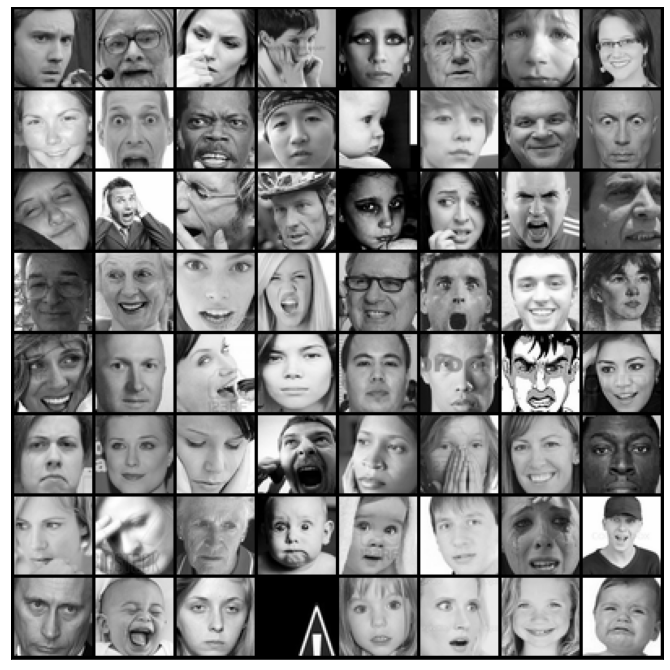

In [8]:
#plotting a set of images
for images, labels in train_dataloader:
    fig, ax = plt.subplots(figsize = (12,12))
    ax.set_xticks([]); ax.set_yticks([])
    denorm_imgs = (images*train_stds) + train_means
    ax.imshow(make_grid(denorm_imgs[:64], nrow = 8).permute(1,2,0).clamp(0,1))
    break

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [10]:
def check_accuracy(loader, model):
    
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
          x = x.to(device = device)
          y = y.to(device = device)
          scores = model(x)
          predictions = scores.argmax(1)
          num_correct += sum((predictions == y))
          num_samples += predictions.size(0)
            
    return float(num_correct)/float(num_samples)

In [11]:
def basic_test(architecture):
    model = architecture().to(device)
    model = model.to(device = device)
    x = torch.randn(batch_size,1,48,48)
    x = x.to(device = device)
    start = time.process_time()
    print(model(x).shape)
    end = time.process_time()
    print("time: ", end-start)

In [12]:
def model_train(model, train_loader, val_loader):
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    model = model.to(device = device)
    history = {"train_accs": [], "val_accs": [], "losses":[], "lrs": []}

    optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
    scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.025,cycle_momentum=False, step_size_up=5, mode="triangular2")
    skips = [i for i in range(10, epochs ,10)]
    loss_fun = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        start = time.process_time()
        model.train()
        loss_train = 0
        for batch, (data,targets) in enumerate(train_loader):
            data = data.to(device = device)
            data = data.float()
            targets = targets.to(device= device)
            
            #fw_prop
            scores = model(data)
            loss = loss_fun(scores, targets)

            #bw_prop
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
            loss_train += loss.item()

            #Optimizer
            optimizer.step()
            
            
        history["lrs"].append(optimizer.param_groups[0]["lr"])

        scheduler.step()
        #if epoch in skips:
        #  for j in range(10):
        #     scheduler.step()
                
        history["train_accs"].append(check_accuracy(train_loader, model))
        history["val_accs"].append(check_accuracy(val_loader, model))
        history["losses"].append(loss_train/(len(train_loader)))
            
        end = time.process_time()
        exec_time = end-start

        print('Epoch ({}/{}),Training loss : {:.4f}, Time: {:.2f},Last lr: {:.5f} train_accuracy:{:.4f}, val_accuracy:{:.4f}'.format(
             epoch+1, epochs, history["losses"][-1], exec_time, history["lrs"][-1], history["train_accs"][-1], history["val_accs"][-1]))

    return model, history

In [13]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias = False), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    
    if pool: layers.append(nn.MaxPool2d(2))
    
    return nn.Sequential(*layers)

In [14]:
class Arch(nn.Module):
  def __init__(self, in_channels = 1, num_classes = 7):
    super(Arch, self).__init__()
    self.conv1 = conv_block(in_channels, 8)
    self.res1 = nn.Sequential(conv_block(8,8),
                              nn.Conv2d(8, 8, kernel_size = 3, padding = 1, bias = False),
                              nn.BatchNorm2d(8))
    self.conv2 = conv_block(8, 16, pool = True)
    self.conv3 = conv_block(16,32)
    self.conv4 = conv_block(32, 64, pool = True)
    self.res2 = nn.Sequential(conv_block(64,64),
                              nn.Conv2d(64, 64, kernel_size = 3, padding = 1, bias = False),
                              nn.BatchNorm2d(64))
    self.conv5 = conv_block(64, 128, pool = True)
    self.conv6 = conv_block(128,256)
    self.conv7 = conv_block(256, 512, pool = True)
    self.res3 = nn.Sequential(conv_block(512,512),
                              nn.Conv2d(512, 512, kernel_size = 3, padding = 1, bias = False),
                              nn.BatchNorm2d(512))
    self.final_pool = nn.AvgPool2d(3)
    self.output = nn.Linear(512, num_classes)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.res1(x) + x
    x = F.relu(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.res2(x) + x
    x = F.relu(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.conv7(x)
    x = self.res3(x) + x
    x = F.relu(x)
    x = self.final_pool(x)
    x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
    x = self.output(x)

    return x

In [15]:
basic_test(Arch)

torch.Size([256, 7])
time:  0.06545216499999995


In [16]:
t1 = time.process_time()
model = Arch()
model, history = model_train(model, train_dataloader, val_dataloader)
t2 = time.process_time()
print("Total time: ", t2-t1)

Epoch (1/25),Training loss : 1.5141, Time: 51.58,Last lr: 0.00100 train_accuracy:0.3441, val_accuracy:0.3349
Epoch (2/25),Training loss : 1.3701, Time: 51.40,Last lr: 0.00580 train_accuracy:0.4837, val_accuracy:0.4787
Epoch (3/25),Training loss : 1.2514, Time: 51.28,Last lr: 0.01060 train_accuracy:0.5345, val_accuracy:0.5230
Epoch (4/25),Training loss : 1.1355, Time: 51.00,Last lr: 0.01540 train_accuracy:0.4989, val_accuracy:0.4742
Epoch (5/25),Training loss : 1.0301, Time: 50.80,Last lr: 0.02020 train_accuracy:0.5508, val_accuracy:0.5266
Epoch (6/25),Training loss : 0.9590, Time: 50.72,Last lr: 0.02500 train_accuracy:0.4671, val_accuracy:0.4400
Epoch (7/25),Training loss : 0.8581, Time: 50.79,Last lr: 0.02020 train_accuracy:0.5746, val_accuracy:0.5149
Epoch (8/25),Training loss : 0.7492, Time: 50.96,Last lr: 0.01540 train_accuracy:0.5790, val_accuracy:0.5040
Epoch (9/25),Training loss : 0.6342, Time: 50.61,Last lr: 0.01060 train_accuracy:0.7080, val_accuracy:0.5720
Epoch (10/25),Train

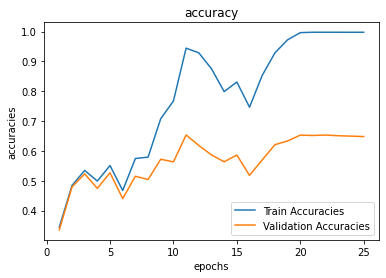

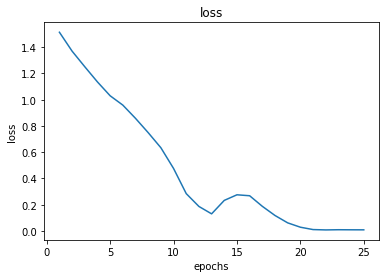

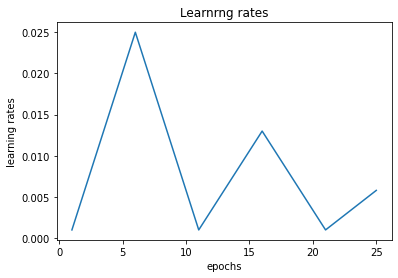

In [17]:
epochs_range = [i+1 for i in range(epochs)]
plot1 = plt.figure(1)
plt.plot(epochs_range,history["train_accs"], label = 'Train Accuracies')
plt.plot(epochs_range,history["val_accs"], label = 'Validation Accuracies')
plt.xlabel("epochs")
plt.ylabel("accuracies")
plt.title('accuracy')
plt.legend()

plot2 = plt.figure(2)
plt.plot(epochs_range,history["losses"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title('loss')
plt.show()

plot2 = plt.figure(3)
plt.plot(epochs_range,history["lrs"])
plt.xlabel("epochs")
plt.ylabel("learning rates")
plt.title('Learnrng rates')
plt.show()

In [18]:
print("Test Accuracy: ",check_accuracy(test_dataloader, model))

Test Accuracy:  0.6324881582613542
